In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [2]:
airports = ['VABB', 'VOTV', 'VOBL', 'VECC', 'VIDP']

def get_visibility(code):
    arr = np.load("visibility_arr.npy")
    idx = airports.index(code)
    return arr[:, idx].astype(np.float32)

def get_era_full(param, level):
    arr = np.load("18To20{}{}_uint8.npy".format(param, level))
    return arr.astype(np.float32)

In [3]:
# Import data
params = ["z", "z", "z"]
levels = [500, 700, 1000]

in1_var = get_era_full(params[0], levels[0])
in2_var = get_era_full(params[1], levels[1])
in3_var = get_era_full(params[2], levels[2])

In [4]:
# data for a given airport
X = np.concatenate((np.expand_dims(in1_var, axis=3), np.expand_dims(in2_var, axis=3), np.expand_dims(in3_var, axis=3)), axis=3)
Y = get_visibility('VOBL').reshape(-1, 1)

In [5]:
# normalizing the output
Y = Y/np.max(Y)

In [6]:
X.shape, X.dtype, Y.shape, X.dtype

((26280, 157, 157, 3), dtype('float32'), (26280, 1), dtype('float32'))

In [7]:
26280*0.7, 26280*0.9

(18396.0, 23652.0)

In [8]:
# splitting the data
X_train, Y_train = X[:18396], Y[:18396]
X_val, Y_val = (X[18396:23652], Y[18396:23652])
X_test, Y_test = (X[23652:], Y[23652:])

In [9]:
conv_base = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(157, 157, 3))


In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 157, 157, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 157, 157, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 157, 157, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 78, 78, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 78, 78, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 78, 78, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 39, 39, 128)       0     

In [11]:
len(conv_base.layers)

19

In [12]:
# preprocess_input

train_features = tf.keras.applications.vgg16.preprocess_input(X_train)
val_features = tf.keras.applications.vgg16.preprocess_input(X_val)
test_features = tf.keras.applications.vgg16.preprocess_input(X_test)

"""# Resizing image

size = (600,600)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
reshaped_train_dataset = train_dataset.map(lambda image, label: (tf.image.resize(image, size), label))
reshaped_train_dataset = reshaped_train_dataset.batch(32)
#reshaped_train_dataset = np.expand_dims(reshaped_train_dataset, axis=0)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
reshaped_val_dataset = val_dataset.map(lambda image, label: (tf.image.resize(image, size), label))
reshaped_val_dataset = reshaped_val_dataset.batch(32)
#reshaped_val_dataset = np.expand_dims(reshaped_val_dataset, axis=0)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
reshaped_test_dataset = test_dataset.map(lambda image, label: (tf.image.resize(image, size), label))
reshaped_test_dataset = reshaped_test_dataset.batch(32)"""
print()

In [13]:
train_features = conv_base.predict(X_train)
val_features = conv_base.predict(X_val)
test_features = conv_base.predict(X_test)

train_labels = Y_train
val_labels = Y_val
test_labels = Y_test

In [14]:
train_features.shape, train_labels.shape

((18396, 4, 4, 512), (18396, 1))

In [15]:
# simple baseline
train_labels_mean = np.mean(train_labels)
simple_baseline_mae = np.mean(np.abs(test_labels - train_labels_mean))
simple_baseline_mape = np.mean(((np.abs(test_labels - train_labels_mean))/test_labels)*100)
print(simple_baseline_mae, simple_baseline_mape)

0.17493102 96.82741


In [16]:
# model building
inputs = keras.Input(shape = (4,4,512))
x = layers.GlobalAveragePooling2D()(inputs)
x = layers.BatchNormalization()(x)
top_dropout_rate = 0.4
x = layers.Dropout(top_dropout_rate)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs, name="vgg16")

In [17]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 4, 512)]       0         
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 2,561
Trainable params: 1,537
Non-trainable par

In [18]:
# compiling the model
#import tensorflow_addons as tfa

#opt = tfa.optimizers.RectifiedAdam(learning_rate=0.001)
#opt = tfa.optimizers.Lookahead(opt, sync_period=6, slow_step_size=0.5)
opt =tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(loss = 'mae', optimizer = opt, metrics = [tf.keras.losses.MeanAbsoluteError()])#, tf.keras.losses.MeanAbsolutePercentageError()])
callbacks = [keras.callbacks.ModelCheckpoint(filepath = "visibilityVOBL_vgg16.keras",
                                            save_best_only = True, monitor = "val_loss")]

In [19]:
history = model.fit(train_features, train_labels, batch_size = 128, epochs = 300, validation_data = (val_features, val_labels), verbose = 0)#, callbacks = callbacks)

In [20]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

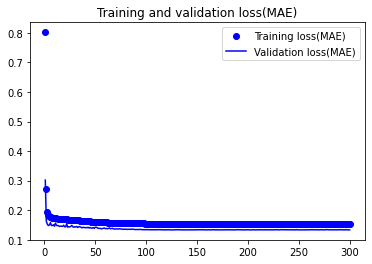

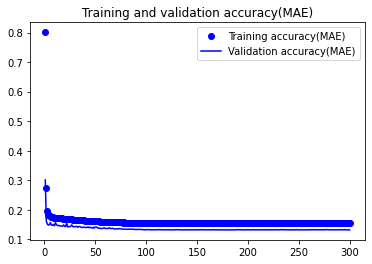

In [21]:
import matplotlib.pyplot as plt
mae = history.history["mean_absolute_error"]
loss = history.history["loss"]
#mape = history.history["mean_absolute_percentage_error"]
val_mae = history.history["val_mean_absolute_error"]
val_loss = history.history["val_loss"]
#val_mape = history.history["val_mean_absolute_percentage_error"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label = "Training loss(MAE)")
plt.plot(epochs, val_loss, "b", label = "Validation loss(MAE)")
plt.title("Training and validation loss(MAE)")
plt.legend()

plt.figure()
plt.plot(epochs, mae, "bo", label = "Training accuracy(MAE)")
plt.plot(epochs, val_mae, "b", label = "Validation accuracy(MAE)")
plt.title("Training and validation accuracy(MAE)")
plt.legend()

"""plt.figure()
plt.plot(epochs, mape, "bo", label = "Training accuracy(MAPE)")
plt.plot(epochs, val_mape, "b", label = "Validation accuracy(MAPE)")
plt.title("Training and validation accuracy(MAPE)")
plt.legend()"""

plt.show()

In [22]:
test_loss, test_mae = model.evaluate(test_features, test_labels)
print(f"Test MAE: {test_mae:.3f}")
print(f"Test MAPE: {test_mape:.3f}")

83/83 [==============================] - 0s 2ms/step - loss: 0.1514 - mean_absolute_error: 0.1530
Test MAE: 0.153


NameError: name 'test_mape' is not defined

0.06678587


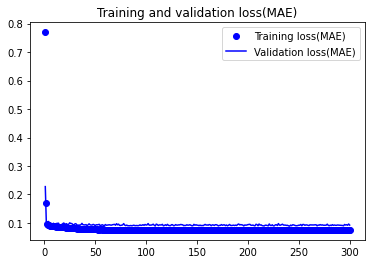

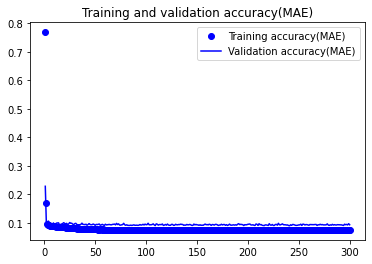

83/83 [==============================] - 0s 3ms/step - loss: 0.0550 - mean_absolute_error: 0.0552
Test MAE: 0.055


In [23]:
#!/usr/bin/env python
# coding: utf-8

# In[3]:


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


# In[4]:


airports = ['VABB', 'VOTV', 'VOBL', 'VECC', 'VIDP']

def get_visibility(code):
    arr = np.load("visibility_arr.npy")
    idx = airports.index(code)
    return arr[:, idx].astype(np.float32)

def get_era_full(param, level):
    arr = np.load("18To20{}{}_uint8.npy".format(param, level))
    return arr.astype(np.float32)


# In[5]:


# Import data
params = ["z", "z", "z"]
levels = [500, 700, 1000]

in1_var = get_era_full(params[0], levels[0])
in2_var = get_era_full(params[1], levels[1])
in3_var = get_era_full(params[2], levels[2])


# In[6]:


# data for a given airport
X = np.concatenate((np.expand_dims(in1_var, axis=3), np.expand_dims(in2_var, axis=3), np.expand_dims(in3_var, axis=3)), axis=3)
Y = get_visibility('VABB').reshape(-1, 1)


# In[7]:


# normalizing the output
Y = Y/np.max(Y)


# In[8]:


#X.shape, X.dtype, Y.shape, X.dtype


# In[9]:


#26280*0.7, 26280*0.9


# In[10]:


# splitting the data
X_train, Y_train = X[:18396], Y[:18396]
X_val, Y_val = (X[18396:23652], Y[18396:23652])
X_test, Y_test = (X[23652:], Y[23652:])


# In[ ]:





# In[11]:


conv_base = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(157, 157, 3))


# In[12]:


#conv_base.summary()


# In[13]:


#len(conv_base.layers)


# In[14]:


# preprocess_input

train_features = tf.keras.applications.vgg16.preprocess_input(X_train)
val_features = tf.keras.applications.vgg16.preprocess_input(X_val)
test_features = tf.keras.applications.vgg16.preprocess_input(X_test)



# In[15]:


train_features = conv_base.predict(X_train)
val_features = conv_base.predict(X_val)
test_features = conv_base.predict(X_test)

train_labels = Y_train
val_labels = Y_val
test_labels = Y_test


# In[16]:


#train_features.shape, train_labels.shape


# In[17]:


# simple baseline
train_labels_mean = np.mean(train_labels)
simple_baseline_mae = np.mean(np.abs(test_labels - train_labels_mean))
#simple_baseline_mape = np.mean(((np.abs(test_labels - train_labels_mean))/test_labels)*100)
print(simple_baseline_mae)#, simple_baseline_mape)


# In[ ]:





# In[33]:


# model building
inputs = keras.Input(shape = (4,4,512))
x = layers.GlobalAveragePooling2D()(inputs)
x = layers.BatchNormalization()(x)
top_dropout_rate = 0.4
x = layers.Dropout(top_dropout_rate)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs, name="vgg16")


# In[34]:


#model.summary()


# In[35]:


# compiling the model
#import tensorflow_addons as tfa

#opt = tfa.optimizers.RectifiedAdam(learning_rate=0.001)
#opt = tfa.optimizers.Lookahead(opt, sync_period=6, slow_step_size=0.5)
opt =tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(loss = 'mae', optimizer = opt, metrics = [tf.keras.losses.MeanAbsoluteError()])#, tf.keras.losses.MeanAbsolutePercentageError()])
callbacks = [keras.callbacks.ModelCheckpoint(filepath = "visibilityVABB_VGG16.keras",
                                             save_best_only = True, monitor = "val_loss")]


# In[36]:


history = model.fit(train_features, train_labels, batch_size = 128, epochs = 300, validation_data = (val_features, val_labels), verbose = 0)#, callbacks = callbacks)


# In[37]:


#history.history.keys()


# In[38]:


import matplotlib.pyplot as plt
mae = history.history["mean_absolute_error"]
loss = history.history["loss"]
#mape = history.history["mean_absolute_percentage_error"]
val_mae = history.history["val_mean_absolute_error"]
val_loss = history.history["val_loss"]
#val_mape = history.history["val_mean_absolute_percentage_error"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label = "Training loss(MAE)")
plt.plot(epochs, val_loss, "b", label = "Validation loss(MAE)")
plt.title("Training and validation loss(MAE)")
plt.legend()

plt.figure()
plt.plot(epochs, mae, "bo", label = "Training accuracy(MAE)")
plt.plot(epochs, val_mae, "b", label = "Validation accuracy(MAE)")
plt.title("Training and validation accuracy(MAE)")
plt.legend()

"""plt.figure()
plt.plot(epochs, mape, "bo", label = "Training accuracy(MAPE)")
plt.plot(epochs, val_mape, "b", label = "Validation accuracy(MAPE)")
plt.title("Training and validation accuracy(MAPE)")
plt.legend()"""

plt.show()


# In[39]:


test_loss, test_mae = model.evaluate(test_features, test_labels)
print(f"Test MAE: {test_mae:.3f}")
#print(f"Test MAPE: {test_mape:.3f}")


# In[ ]:





0.12273914


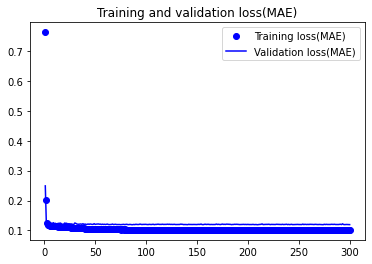

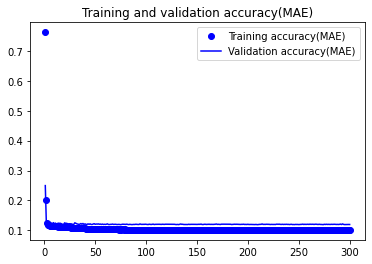

83/83 [==============================] - 0s 3ms/step - loss: 0.1168 - mean_absolute_error: 0.1175
Test MAE: 0.118


In [24]:
#!/usr/bin/env python
# coding: utf-8

# In[3]:


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


# In[4]:


airports = ['VABB', 'VOTV', 'VOBL', 'VECC', 'VIDP']

def get_visibility(code):
    arr = np.load("visibility_arr.npy")
    idx = airports.index(code)
    return arr[:, idx].astype(np.float32)

def get_era_full(param, level):
    arr = np.load("18To20{}{}_uint8.npy".format(param, level))
    return arr.astype(np.float32)


# In[5]:


# Import data
params = ["z", "z", "z"]
levels = [500, 700, 1000]

in1_var = get_era_full(params[0], levels[0])
in2_var = get_era_full(params[1], levels[1])
in3_var = get_era_full(params[2], levels[2])


# In[6]:


# data for a given airport
X = np.concatenate((np.expand_dims(in1_var, axis=3), np.expand_dims(in2_var, axis=3), np.expand_dims(in3_var, axis=3)), axis=3)
Y = get_visibility('VOTV').reshape(-1, 1)


# In[7]:


# normalizing the output
Y = Y/np.max(Y)


# In[8]:


#X.shape, X.dtype, Y.shape, X.dtype


# In[9]:


#26280*0.7, 26280*0.9


# In[10]:


# splitting the data
X_train, Y_train = X[:18396], Y[:18396]
X_val, Y_val = (X[18396:23652], Y[18396:23652])
X_test, Y_test = (X[23652:], Y[23652:])


# In[ ]:





# In[11]:


conv_base = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(157, 157, 3))


# In[12]:


#conv_base.summary()


# In[13]:


#len(conv_base.layers)


# In[14]:


# preprocess_input

train_features = tf.keras.applications.vgg16.preprocess_input(X_train)
val_features = tf.keras.applications.vgg16.preprocess_input(X_val)
test_features = tf.keras.applications.vgg16.preprocess_input(X_test)




# In[15]:


train_features = conv_base.predict(X_train)
val_features = conv_base.predict(X_val)
test_features = conv_base.predict(X_test)

train_labels = Y_train
val_labels = Y_val
test_labels = Y_test


# In[16]:


#train_features.shape, train_labels.shape


# In[17]:


# simple baseline
train_labels_mean = np.mean(train_labels)
simple_baseline_mae = np.mean(np.abs(test_labels - train_labels_mean))
#simple_baseline_mape = np.mean(((np.abs(test_labels - train_labels_mean))/test_labels)*100)
print(simple_baseline_mae)#, simple_baseline_mape)


# In[ ]:





# In[33]:


# model building
inputs = keras.Input(shape = (4,4,512))
x = layers.GlobalAveragePooling2D()(inputs)
x = layers.BatchNormalization()(x)
top_dropout_rate = 0.4
x = layers.Dropout(top_dropout_rate)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs, name="vgg16")


# In[34]:


#model.summary()


# In[35]:


# compiling the model
#import tensorflow_addons as tfa

#opt = tfa.optimizers.RectifiedAdam(learning_rate=0.001)
#opt = tfa.optimizers.Lookahead(opt, sync_period=6, slow_step_size=0.5)
opt =tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(loss = 'mae', optimizer = opt, metrics = [tf.keras.losses.MeanAbsoluteError()])#, tf.keras.losses.MeanAbsolutePercentageError()])
callbacks = [keras.callbacks.ModelCheckpoint(filepath = "visibilityVOTV_VGG16.keras",
                                             save_best_only = True, monitor = "val_loss")]


# In[36]:


history = model.fit(train_features, train_labels, batch_size = 128, epochs = 300, validation_data = (val_features, val_labels), verbose = 0)#, callbacks = callbacks)


# In[37]:


#history.history.keys()


# In[38]:


import matplotlib.pyplot as plt
mae = history.history["mean_absolute_error"]
loss = history.history["loss"]
#mape = history.history["mean_absolute_percentage_error"]
val_mae = history.history["val_mean_absolute_error"]
val_loss = history.history["val_loss"]
#val_mape = history.history["val_mean_absolute_percentage_error"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label = "Training loss(MAE)")
plt.plot(epochs, val_loss, "b", label = "Validation loss(MAE)")
plt.title("Training and validation loss(MAE)")
plt.legend()

plt.figure()
plt.plot(epochs, mae, "bo", label = "Training accuracy(MAE)")
plt.plot(epochs, val_mae, "b", label = "Validation accuracy(MAE)")
plt.title("Training and validation accuracy(MAE)")
plt.legend()

"""plt.figure()
plt.plot(epochs, mape, "bo", label = "Training accuracy(MAPE)")
plt.plot(epochs, val_mape, "b", label = "Validation accuracy(MAPE)")
plt.title("Training and validation accuracy(MAPE)")
plt.legend()"""

plt.show()


# In[39]:


test_loss, test_mae = model.evaluate(test_features, test_labels)
print(f"Test MAE: {test_mae:.3f}")
#print(f"Test MAPE: {test_mape:.3f}")


# In[ ]:



